In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [30]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine,reflect = True)

In [32]:
# We can view all of the classes that automap found

inspector = inspect(engine)
tables = inspector.get_table_names()

print(tables)


['measurement', 'station']


In [33]:
# Display Column Names 

station_c=inspector.get_columns('station')
for column in station_c:
    print(column['name'],column['type'])
    
print("-------------------------------------")


measurement_c=inspector.get_columns("measurement")
for column in measurement_c:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-------------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement


In [35]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Climate Analysis

2017-08-23
Measured last date: 2017-08-23 00:00:00
To query the above: 2016-08-23


Text(0.5, 1.0, 'Precipitation Data from 2016-08-23 to 2017-08-23')

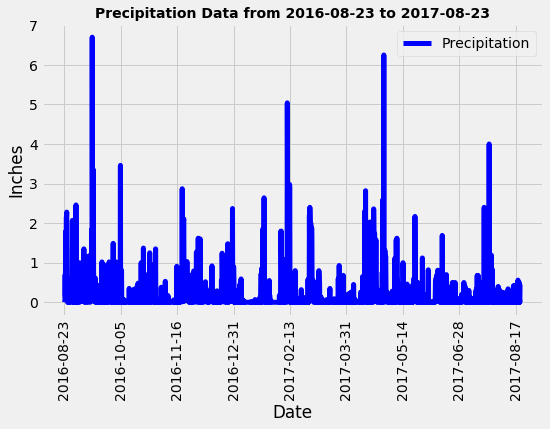

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

prcp_lastyear = pd.DataFrame(session.query(Measurement.date,Measurement.prcp)
                             .filter(Measurement.date >= dt.date(2016,8,23)),columns=['Date','Precipitation'])

prcp_lastyear.head()
# Calculate the date 1 year ago from the last data point in the database

last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_data_point)
last_date = dt.datetime.strptime(last_data_point , "%Y-%m-%d")
print(f"Measured last date: {last_date}")
first_date = dt.date(last_date.year-1,last_date.month,last_date.day)
print(f"To query the above: {first_date}")

# Perform a query to retrieve the data and precipitation scores

scores = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= first_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

scores_df = pd.DataFrame(scores,columns=['Date','Precipitation']).set_index('Date')
scores_df.head()

scores_df = scores_df.dropna()

# Sort the dataframe by date

scores_df=scores_df.sort_index()
scores_df

# Use Pandas Plotting with Matplotlib to plot the data

graph = scores_df.plot(rot=90,color='Blue',figsize=(8,5),linewidth =5)
graph.set_xlabel('Date')
graph.set_ylabel('Inches')
graph.set_title('Precipitation Data from 2016-08-23 to 2017-08-23',fontsize = 14,fontweight='bold')


In [88]:
# Use Pandas to calcualte the summary statistics for the precipitation data

scores_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [90]:
# Design a query to show how many stations are available in this dataset?

total_stations = session.query(Station.station).count()
print(f"There are a total of {total_stations} stations in this dataset")


There are a total of 9 stations in this dataset


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations = pd.DataFrame(session.query(Measurement.station,Measurement.prcp),columns=['Station','Observation Counts']).groupby('Station').count().sort_values('Observation Counts', ascending = False)

 
active_station = active_stations.index[0]
print(f"{active_station} is the most active station with 2772 observations.")
                               
                            

# List the stations and the counts in descending order.
active_stations

USC00519281 is the most active station with 2772 observations.


,Observation Counts
Station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [125]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = active_stations.index[0]

active_min_temp, active_max_temp,active_avg_temp = session.query(func.min(Measurement.tobs),\
                                                         func.max(Measurement.tobs),\
                                                         func.avg(Measurement.tobs))\
                                                         .filter(Measurement.station == active_station)\
                                                          .all()[0]

print(f"The highest temperature of the {active_station} is {active_max_temp},\n\
The lowest temperature of the {active_station} is {active_min_temp},\n\
The average temperature of the {active_station} is {round(active_avg_temp,1)}\
")



The highest temperature of the USC00519281 is 85.0,
The lowest temperature of the USC00519281 is 54.0,
The average temperature of the USC00519281 is 71.7


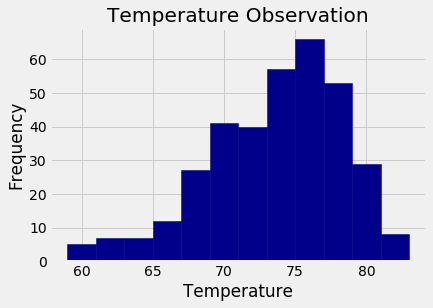

In [138]:
# Choose the station with the highest number of temperature observations

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


lastyear_tobs = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.date >= first_date)\
                .filter(Measurement.station==active_station),\
                columns=['Date','Temperature Observation'])

lastyear_tobs= lastyear_tobs.dropna()
lastyear_tobs

hist_temp = lastyear_tobs.hist(bins =12, facecolor='DarkBlue', edgecolor= "DarkBlue")
for ht in hist_temp.flatten():
    ht.set_xlabel("Temperature")
    ht.set_ylabel("Frequency")
    
                                
            
                


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
